In [1]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import logging
logging.getLogger("transformers.tokenization_utils_base").setLevel(logging.ERROR)
from torch.utils.data import Dataset


In [2]:
import pandas as pd
data = pd.read_csv('Processed_data.csv')
df = pd.read_csv("DataScientist.csv" , index_col=0).drop("index",axis=1)
data


,Prompt,Target
0,Write a job description for AI Scientist role ...,Paige is a software company helping pathologis...
1,Write a job description for Quantitative Resea...,"About the Position\n\n\nAt Jane Street, we con..."
2,"Write a job description for VP, Data Science r...","We are looking for a VP, Data Science to lead ..."
3,Write a job description for Quantitative Resea...,Job Description\n\nQuantitative Researchers at...
4,Write a job description for Senior Data Engine...,"Key Responsibilities\n\n- Architect, build, an..."
...,...,...
1023,Write a job description for JPSC-7975 - Data A...,Overview\n\nRole: Data Analyst Lead – Informat...
1024,Write a job description for Principal Data Eng...,ComResource is looking for a Principal Data En...
1025,Write a job description for Columbus Data Scie...,#Columbus Data Science Tutor Jobs\n\nVarsity T...
1026,Write a job description for AWS Data Engineer ...,About Us\n\nTachyon Technologies is a Digital ...


In [3]:
from datasets import Dataset
dataset = Dataset.from_pandas(data)
dataset

/home/wailk/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset({
    features: ['Prompt', 'Target'],
    num_rows: 1028
})

In [4]:
datasets = dataset.train_test_split(train_size=0.8,seed=42)
datasets["validation"] = datasets.pop("test")
datasets

DatasetDict({
    train: Dataset({
        features: ['Prompt', 'Target'],
        num_rows: 822
    })
    validation: Dataset({
        features: ['Prompt', 'Target'],
        num_rows: 206
    })
})

In [5]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorWithPadding, Trainer, TrainingArguments

2024-08-11 15:20:30.248658: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-11 15:20:30.375051: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-11 15:20:30.426279: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-11 15:20:30.441088: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-11 15:20:30.532225: I tensorflow/core/platform/cpu_feature_guar

In [6]:
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")

/home/wailk/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [7]:
model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base")

In [8]:
def tokenize_function(example):

    tokenized_prompt = tokenizer(example['Prompt'], truncation=True, padding=True)
    tokenized_target = tokenizer(example['Target'], truncation=True, padding='max_length', max_length=512)

    return {
        'input_ids': tokenized_prompt['input_ids'],
        'attention_mask': tokenized_prompt['attention_mask'],
        'labels': tokenized_target['input_ids']
    }



In [9]:
tokenized_datasets = datasets.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/822 [00:00<?, ? examples/s]

Map: 100%|██████████| 206/206 [00:00<00:00, 2250.41 examples/s]


In [10]:
tokenized_datasets = tokenized_datasets.remove_columns(['Prompt', 'Target'])
tokenized_datasets.set_format("torch")

In [11]:
tokenized_datasets["validation"].column_names

['input_ids', 'attention_mask', 'labels']

In [12]:
tokenized_datasets["train"].column_names

['input_ids', 'attention_mask', 'labels']

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
device

device(type='cpu')

In [14]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    tokenized_datasets["train"], shuffle=True, batch_size=2, collate_fn=data_collator
)
val_dataloader = DataLoader(
    tokenized_datasets["validation"], batch_size=8, collate_fn=data_collator
)



In [15]:
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

/home/wailk/.local/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [16]:
from transformers import get_scheduler

num_epochs = 10
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)
print(num_training_steps)

4110


In [17]:
from torch.cuda.amp import GradScaler, autocast

100%|██████████| 4110/4110 [14:00:50<00:00, 13.26s/it]   

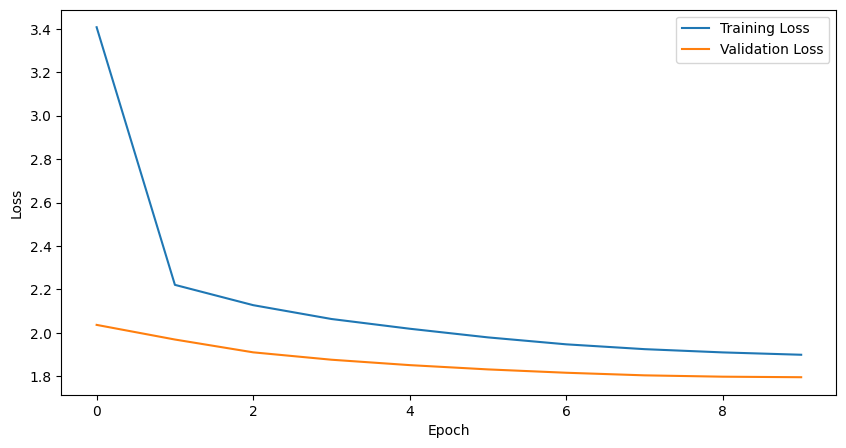

In [18]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))
training_losses = []  # To store training losses
validation_losses = []  # To store validation losses

model.train()
for epoch in range(num_epochs):
    epoch_training_loss = 0.0

    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        epoch_training_loss += loss.item()

        progress_bar.update(1)

    # Calculate and record the average training loss for the epoch
    avg_training_loss = epoch_training_loss / len(train_dataloader)
    training_losses.append(avg_training_loss)

    # Calculate the validation loss at the end of each epoch
    model.eval()
    with torch.no_grad():
        epoch_validation_loss = 0.0
        for batch in val_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            epoch_validation_loss += loss.item()

        avg_validation_loss = epoch_validation_loss / len(val_dataloader)
        validation_losses.append(avg_validation_loss)

    model.train()

# Plot the training and validation losses variation over the epochs
plt.figure(figsize=(10, 5))
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [19]:
display(pd.DataFrame({'epoch':[1,2,3,4,5,6,7,8,9,10], 'Training loss':training_losses, 'Validation loss':validation_losses}).set_index('epoch'))

,Training loss,Validation loss
epoch,,
1,3.407310,2.036819
2,2.221094,1.969401
3,2.127615,1.910409
4,2.063890,1.876398
5,2.019064,1.851532
6,1.979201,1.831808
7,1.947234,1.816399
8,1.925052,1.804457
9,1.910078,1.798289


In [21]:

# Save the model, optimizer, and learning rate scheduler
save_path = '/home/wailk/Desktop/JobDescription/model.pth'
torch.save({
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'lr_scheduler_state_dict': lr_scheduler.state_dict(),
    'training_losses': training_losses,
    'validation_losses': validation_losses
}, save_path)

print(f"Model saved to {save_path}")


Model saved to /home/wailk/Desktop/JobDescription/model.pth


In [22]:
def generate_description(prompt):
    """ It takes a prompt as input and return the job description"""
    # Encoding the prompt
    input_ids = tokenizer(prompt, return_tensors='pt', padding = True, truncation=True)['input_ids'].to(device)

    output = model.generate(input_ids, max_length=512) # generates an output

    # Decoding the output to get the generated text
    decoded_output = [tokenizer.decode(output[0], skip_special_tokens=True)][0]
    return decoded_output

In [26]:
job_title = 'networking'
company_name = 'sonatrach'
year = 2019
size = '+200 employees'
industry = 'IT Services industry'
sector = 'Information Technology'
location = 'skikda'
headquarter = 'alger'
salary_estimate = '$50K-$100K'
prompt = f'Write a job description for {job_title} role proposed by "{company_name}", a company founded on {year} that has now a size of {size} and works on {industry} industry in the {sector} sector. The job proposed is in {location} meanwhile the headquarter of the company is in {headquarter}. The salary estimate is {salary_estimate}'
description = generate_description(prompt)

print('prompt :')
print(prompt)
print(' ')
print("model's output :")
print(description[:200])

prompt :
Write a job description for networking role proposed by "sonatrach", a company founded on 2019 that has now a size of +200 employees and works on IT Services industry industry in the Information Technology sector. The job proposed is in skikda meanwhile the headquarter of the company is in alger. The salary estimate is $50K-$100K
 
model's output :
Job Description Job Description - Dedicated to providing the best in customer experience, we are looking for a highly motivated, driven and motivated individual to join our team. The ideal candidate w
